In [7]:
import numpy as np
import sys, os
import csv
import time

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

seed = 0
augment = True
batch_size = 128
alpha = 1.0
max_epoch = 200
name = "mixup(mse)"
init_lr = 0.05
decay = 0.0005
num_classes=10
net_name = "resnet18bn"
mixup = "mixup"

In [8]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()


In [9]:
device = torch.device("cuda:6")
net = ResNet18(num_classes=num_classes).to(device=device)

print(net)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

if seed != 0:
    torch.manual_seed(seed)

# Data
print('==> Preparing data..')
if augment:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])
else:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(root='../dataset', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size, shuffle=True, num_workers=16)

testset = datasets.CIFAR10(root='../dataset', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=16)

logname = 'results/log_' + net_name + '_' + name + '_' + 'cifar10' + '.csv'

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

optimizer = optim.SGD(net.parameters(), lr=init_lr, momentum=0.9, weight_decay=decay)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch)

def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    global device
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device=device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_y = lam * y + (1 - lam) * y[index, :]
    return mixed_x, mixed_y, lam

def convert_onehot(targets):
    '''
    convert natural numbered labels with one-hot vectorized labels.
    '''
    global num_classes
    return F.one_hot(targets, num_classes=num_classes).to(dtype=torch.float)

def so2_mixup_data(x, y, alpha):
    global device
    if alpha > 0:
        theta = np.random.uniform(-np.pi * alpha, np.pi * alpha)
#        theta = np.random.beta(alpha, alpha)
    else:
        theta = 0
        
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device=device)
    
    cos, sin = np.cos(theta), np.sin(theta)
    
    mixed_x1 = cos * x - sin * x[index, :]
    mixed_x2 = sin * x + cos * x[index, :]
    mixed_x = torch.cat((mixed_x1, mixed_x2), 0)

    mixed_y1 = cos * y - sin * y[index, :]
    mixed_y2 = sin * y + cos * y[index, :]
    mixed_y = torch.cat((mixed_y1, mixed_y2), 0)
        
    return mixed_x, mixed_y, theta

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    reg_loss = 0
    correct = 0
    total = 0
    steps = 0
    lam = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device=device), targets.to(device=device)
        targets = convert_onehot(targets)
        inputs, targets, lam = mixup_data(inputs, targets, alpha)
        outputs = net(inputs)
        
        loss = criterion(outputs, targets)
        
        train_loss += loss.data
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        
#        correct += predicted.eq(targets.data).cpu().sum().float()
#        correct += (lam * predicted.eq(targets_a.data).cpu().sum().float()
#                    + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())
        correct += torch.tensor([0])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        steps += 1
        if steps % 40 == 0:
            print('Loss: %.3f | Reg: %.5f | Acc: %.3f%% (%d/%d)' % (train_loss/(batch_idx+1), reg_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return (train_loss/batch_idx, reg_loss/batch_idx, 100.*correct/total)

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device=device), targets.to(device=device)
        outputs = net(inputs)
        
#        loss = criterion(outputs, targets)
        loss = criterion(outputs, convert_onehot(targets))

        test_loss += loss.data
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

#        print('Loss: %.3f | Reg: %.5f | Acc: %.3f%% (%d/%d)' % (train_loss/(batch_idx+1), reg_loss/(batch_idx+1), 100.*correct/total, correct, total))

    acc = 100.*correct/total
    print(f"Test Acc.: {acc}")
    if acc > best_acc:
        best_acc = acc
    return (test_loss/batch_idx, 100.*correct/total)

if not os.path.exists(logname):
    with open(logname, 'w') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow(['epoch', 'train loss', 'reg loss', 'train acc',
                            'test loss', 'test acc'])

for epoch in range(start_epoch, max_epoch):
    train_loss, reg_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch)
    scheduler.step()
    with open(logname, 'a') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow([epoch, train_loss.item(), reg_loss, train_acc.item(), test_loss.item(), test_acc.item()])
        
print(f"Best Acc.: {best_acc}")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [10]:
net.eval()
correct = 0
for batch_idx, (inputs, targets) in enumerate(trainloader):
    inputs, targets = inputs.to(device=device), targets.to(device=device)
    outputs = net(inputs)
    correct += torch.max(outputs.data, 1)[1].eq(targets.data).cpu().sum()    

    targets = convert_onehot(targets)
    inputs, targets, theta = mixup_data(inputs, targets, 0.25)
    outputs = net(inputs)
    
    errors = torch.mean(torch.abs(outputs - targets), dim=1)
#    errors = torch.squeeze(errors)[:int(inputs.size(0)/2)]
    errors = torch.squeeze(errors)

    
    if batch_idx >= 1:
#        theta_log.extend([theta] * int(inputs.size(0)/2))
        theta_log.extend([theta] * int(inputs.size(0)))
        error_log = torch.cat((error_log, errors.detach().clone()), dim=0)
    else:
#        theta_log = [theta] * int(inputs.size(0)/2)
        theta_log = [theta] * int(inputs.size(0))
        error_log = errors.detach().clone()
    if batch_idx % 200 == 0:
        print(batch_idx)
        
print(correct)

0
200
tensor(49981)


In [11]:
theta_log = np.array(theta_log)
error_log = error_log.cpu().numpy()

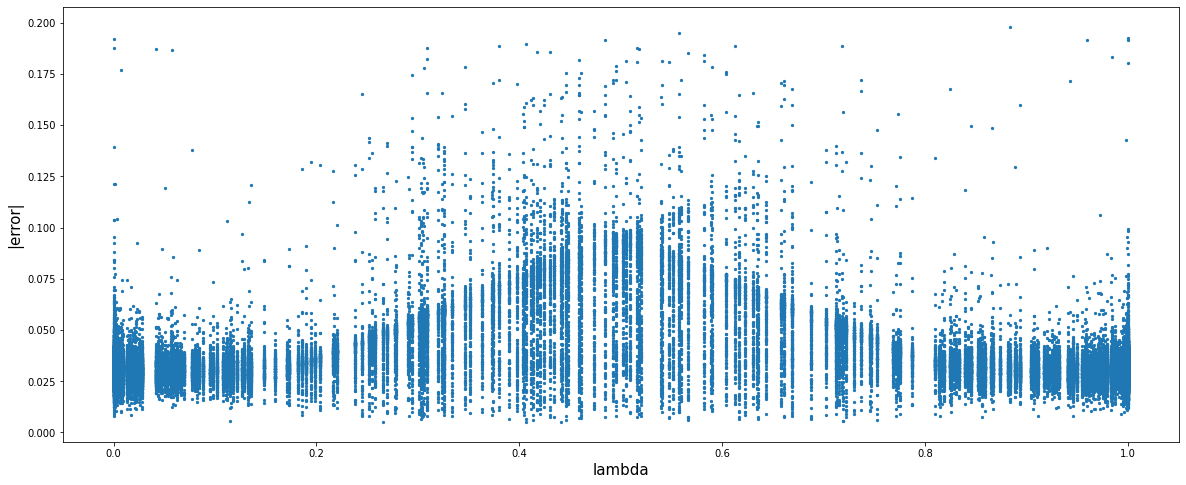

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.scatter(theta_log, error_log, s=5)
plt.xlabel("lambda", fontsize=15)
plt.ylabel("|error|", fontsize=15)
plt.show()

In [ ]:
# -> 100 epoch 100 classes cifar10 so2mixup mse (alpha=0.25)
# 92.53 -> 100 epoch 100 classes cifar10 so2mixup mse (alpha=0.5)
# 94.09 -> 200 epoch 100 classes cifar10 default mse
# -> 200 epoch 100 classes cifar10 mixup mse

# 93.76/94.27/93.31/95.54 -> 100 epochs 10 classes cifar10 so2mixup mse (alpha = 0.25) 
#    so2mixup4/ / so2mixup-beta / so2mixup5 (default, w/ bn, beta(0.2,0.2), beta(0.2,0.2) w/ 400 epoch 16 bsz)
# 92.73 -> 100 epoch 10 classes cifar10 so2mixup mse (alpha=0.5) so2mixup2
# 89.84 -> 100 epoch 10 classes cifar10 so2mixup mse (alpha=1.0) so2mixup3
# -> 200 epoch 10 classes cifar10 default mse
# -> 200 epoch 10 classes cifar10 mixup mse

# 95.65 -> 200 epoch 10 classes cifar10 default ce
# 96.04 -> 200 epoch 10 classes cifar10 mixup ce

In [25]:
x = torch.tensor([1,2]) * 0.3
F.one_hot(x, num_classes=num_classes)

RuntimeError: one_hot is only applicable to index tensor.